<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
%%capture
!apt-get install dcm2niix

In [69]:
%%capture
!pip install pyplastimatch 

In [70]:
%%capture
!apt install plastimatch 

In [71]:
!plastimatch --version

plastimatch version 1.8.0


In [72]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

In [73]:
import os
import time
import pandas as pd

In [74]:
cohort_df= pd.read_csv('/content/drive/MyDrive/bq-results-20230315-160529-1678896367937/bq-results-20230315-160529-1678896367937.csv')


In [75]:
#SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
SeriesInstanceUIDs=[
'1.3.6.1.4.1.14519.5.2.1.7009.9004.318602497855340168746421125221'
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
# '1.2.840.113654.2.55.99651797089556982668213819691341139949',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.232085097739286069987727730632',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.171396052820297460506369313586',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.157523143808189016007292783743',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.120962159182977025862744100528',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.233720172411521069206993854389',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.173170853908044997397123665862',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.142140685181040038525271327574',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.919262012980081990607078665322',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.287814520939797980646993158146'    

    
]

In [76]:
from pathlib import Path
curr_dir   = Path().absolute()
!rm -r dcm2niix plastimatch
!mkdir dcm2niix plastimatch
import subprocess

In [77]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data and run dicomsort to standardise the input format.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmd_cp_url"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat $gs_file_path | gsutil -q -m cp -Ir $download_path >> /dev/null
  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [78]:
import os
import subprocess
cwd = os.getcwd()
def convert_dicom_to_nifti(series_id):
  # !rm -r dcm2niix/{series_id}  
  # !mkdir dcm2niix/{series_id} 
  # !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -v y -o  /content/dcm2niix/{series_id}  /content/idc_data/{series_id}
  #subprocess.run(["dcm2niix", "-z", "y", "-f", "%j_%p_%t_%s", "-b", "n", "-m", "y", "-o",
  #              f"{cwd}/dcm2niix/{series_id}", f"{cwd}/idc_data/{series_id}"])
  !rm -r plastimatch/{series_id} >> /dev/null
  !mkdir plastimatch/{series_id} 
  subprocess.run(["plastimatch", "convert", "--input", f"{cwd}/idc_data/{series_id}",
                "--output-img", f"{cwd}/plastimatch/{series_id}/{series_id}.nii.gz"])
  #To do !plastimatch convert --input $cwd/idc_data/$series_id --output-img $cwd/plastimatch/$series_id/$series_id.nii.gz
  !rm -r idc_data/{series_id} 

In [80]:
import os
import zipfile
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024
            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb

In [81]:
def download_and_process_series(series_id):
    log = pd.DataFrame({'SeriesInstanceUID': [series_id]})

    start_time = time.time()
    download_dicom_data( series_id)
    download_time = time.time() - start_time

    log['download_time'] = download_time

    start_time = time.time()
    convert_dicom_to_nifti(series_id)
    convert_dicom_to_nifti_time = time.time() - start_time

    log['NiftiConverter_time'] = convert_dicom_to_nifti_time

    global runtime_stats
    runtime_stats = runtime_stats.append(log, ignore_index=True)



Copying files from IDC buckets..
Done in 3.25731 seconds.
rm: cannot remove 'plastimatch/1.3.6.1.4.1.14519.5.2.1.7009.9004.318602497855340168746421125221': No such file or directory


<ipython-input-81-c099e7a1ec80>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  runtime_stats = runtime_stats.append(log, ignore_index=True)


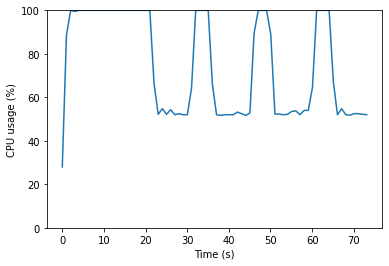

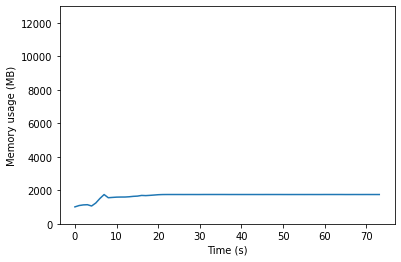

CompletedProcess(args=['zip', '-j', '-r', 'downloadDicomAndConvertNiftiFiles.zip', '/content/plastimatch'], returncode=0)

In [82]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','download_time',
                                      'NiftiConverter_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(download_and_process_series, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb = mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]
                
                
                #runtime_stats.at[runtime_stats['SeriesInstanceUID']==series_id, 'cpu_usage']=[[cpu_usage]]
                #runtime_stats.at[runtime_stats['SeriesInstanceUID']==series_id, 'ram_usage_mb']=[[ram_usage_mb]]
                #runtime_stats.at[runtime_stats['SeriesInstanceUID']==series_id, 'ram_total_mb']=[[ram_total_mb]]

                plt.plot(time_stamps, cpu_usage)
                plt.ylim(0, 100)
                plt.xlabel('Time (s)')
                plt.ylabel('CPU usage (%)')
                plt.show()

                plt.plot(time_stamps, ram_usage_mb)
                plt.ylim(0, ram_total_mb)
                plt.xlabel('Time (s)')
                plt.ylabel('Memory usage (MB)')
                plt.show()

runtime_stats.to_csv('runtime.csv')
subprocess.run(["zip", "-j", "-r", "downloadDicomAndConvertNiftiFiles.zip", os.path.join(curr_dir, "runtime.csv")])
subprocess.run(["zip", "-j", "-r", "downloadDicomAndConvertNiftiFiles.zip", os.path.join(curr_dir, "plastimatch")])

In [83]:
runtime_stats

,SeriesInstanceUID,download_time,NiftiConverter_time,cpu_usage,ram_usage_mb,ram_total_mb
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.318602497855...,3.381384,70.234283,"[[[28.0, 88.6, 100.0, 99.5, 100.0, 100.0, 100....","[[[1010.32421875, 1090.1875, 1128.203125, 1140...",[12985.546875]
